<h1>Fragen</h1>
<h2>Helfen Ampeln bei der Reduktion von Abbiege und Kreuzungsunfällen?</h2>
1. Welche Informationen sind notwendig, um diese Frage beantworten zu können? <br/>
Abgrenzung Abbiege und Kreuzungsunfälle?<br/>
Unfalltyp (technisch UTYP1 )<br/>
2 = Abbiegeunfall<br/>
3 = Einbiegen / Kreuzen-Unfall<br/>
NAHE_AMPEL <br/>
0 = False <br/>
1 = True <br/>

2. Woran erkenne ich, ob/in welchem Maß die Ampel geholfen hat? <br/>
Durchschnittliche Anzahl an Unfällen um eine Ampel rum im Vergleich zu Kreuzungen, an denen es keine Ampel gab (Visuelle Erkenntnis) <br/>
Warum keine analytische Erkenntnis? --> Notwendige Daten fehlen, um das vergleichen zu können müsste, aber mithilfe von Clustering könnte eine Gruppenbildung vorgenommen werden<br/>
Verkehrsmenge auf Straßenabschnitten <br/>
Verkehrsmenge auf Straßenabschnitten ggf. Kategorisierung in hohes Verehrsaufkommen, mittleres, niedriges  <br/>
Vergleich von Bezirken Anzahl Ampeln je durchschnittliche Verkehrsmenge <br/>
Tempolimits einbringen <br/>

## 1. Vorbereitung des Datensatzes

### 1.1 Generelles Aufbereiten der Datenbasis

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
crash_data = gpd.read_file('../01_Source/U_VM_A_L_BRW_TL.geojson') 
geo_information = pd.read_csv('../01_Source/geo_information.csv', sep=';')

In [2]:
crash_data.head()

,OBJECTID,ULAND,UREGBEZ,UKREIS,UGEMEINDE,UJAHR,UMONAT,USTUNDE,UWOCHENTAG,UKATEGORIE,UART,UTYP1,ULICHTVERH,IstRad,IstPKW,IstFuss,IstKrad,IstGkfz,IstSonstige,STRZUSTAND,LINREFX,LINREFY,METER,STR_NAME,DTV,PKW,LKW,LIEFERWAGEN,LINIENBUSSE,REISEBUSSE,KRAD,HERKUNFT,NAME,KNAME,PLR_NAME,EW2010,VBUS,VBUS_PERS,GESLAERM,GESLAERM_PERS,GEMEINDE,BEZIRK,ANWERT,BRW,NUTZUNG,GFZ,VERFAHRENSART,STICHTAG,BEITRAGSZUSTAND,LUMNUM,ELEM_NR,VRICHT_TXT,WERT_VES,ZEIT_T,TAG_T,DURCH_T,DANN_T,DAT_T,geometry
0,198728,11,0,10,10,2018,3,11,5,3,5,3,0,0,1,0,0,0,0,0,814987.3095,5.829184e+06,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,Mahlsdorf Nord,8818.0,mittel,niedrig - sehr niedrig,mittel,niedrig - sehr niedrig,Berlin,Marzahn-Hellersdorf,None,360,W - Wohngebiet,0.4,None,2019-01-01T00:00:00,Beitragsfrei nach BauGB,[[url]],62540035_62540036.02,beide Richtungen,30.0,None,None,angeordnete Verkehrseinschränkung,None,None,"MULTIPOLYGON (((814997.310 5829184.012, 814996..."
1,196865,11,0,10,10,2018,1,18,2,3,5,3,2,0,1,0,0,0,0,0,814875.2039,5.830058e+06,220.0,Lemkestr.,6108.0,4995.0,220.0,624.0,160.0,16.0,93.0,"Modellrechnung 2014, VMZ",None,None,Mahlsdorf Nord,8818.0,mittel,niedrig - sehr niedrig,mittel,niedrig - sehr niedrig,Berlin,Marzahn-Hellersdorf,None,360,W - Wohngebiet,0.4,None,2019-01-01T00:00:00,Beitragsfrei nach BauGB,[[url]],62550001_62550021.01,beide Richtungen,30.0,07:00 - 17:00,Montag bis Freitag,Kinder,Zeitangabe,None,"MULTIPOLYGON (((814885.204 5830057.780, 814884..."
2,202456,11,0,10,10,2018,6,7,4,2,5,3,0,1,1,0,0,0,0,0,814271.9549,5.828041e+06,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,Alt-Mahlsdorf,3852.0,niedrig - sehr niedrig,niedrig - sehr niedrig,niedrig - sehr niedrig,mittel,Berlin,Marzahn-Hellersdorf,None,360,W - Wohngebiet,0.4,None,2019-01-01T00:00:00,Beitragsfrei nach BauGB,[[url]],62530003_62540023.02,beide Richtungen,30.0,None,None,angeordnete Verkehrseinschränkung,None,None,"MULTIPOLYGON (((814281.955 5828040.742, 814281..."
3,201726,11,0,10,10,2018,6,13,4,3,5,3,0,0,1,0,0,1,0,0,814205.0080,5.830068e+06,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,Mahlsdorf Nord,8818.0,mittel,niedrig - sehr niedrig,mittel,niedrig - sehr niedrig,Berlin,Marzahn-Hellersdorf,None,360,W - Wohngebiet,0.4,None,2019-01-01T00:00:00,Beitragsfrei nach BauGB,[[url]],62550008_62550009.03,beide Richtungen,30.0,None,None,angeordnete Verkehrseinschränkung,None,None,"MULTIPOLYGON (((814215.008 5830068.156, 814214..."
4,200478,11,0,10,10,2018,5,20,7,3,5,3,1,0,1,0,0,0,0,0,814755.4276,5.829893e+06,254.0,Lemkestr.,3852.0,3127.0,107.0,393.0,150.0,16.0,59.0,"Modellrechnung 2014, VMZ",None,None,Mahlsdorf Nord,8818.0,mittel,niedrig - sehr niedrig,mittel,niedrig - sehr niedrig,Berlin,Marzahn-Hellersdorf,None,360,W - Wohngebiet,0.4,None,2019-01-01T00:00:00,Beitragsfrei nach BauGB,[[url]],62550028_62550029.02,beide Richtungen,30.0,None,None,angeordnete Verkehrseinschränkung,None,None,"MULTIPOLYGON (((814765.428 5829893.128, 814764..."


In [3]:
affected_crash_data = crash_data[((crash_data['UTYP1'] == 2) | (crash_data['UTYP1'] == 3))]

In [4]:
affected_crash_data.shape

(6163, 59)

In [5]:
# Feld Nahe Ampel erzeugen
affected_crash_data['NAHE_AMPEL'] = 0
affected_crash_data.loc[~affected_crash_data["KNAME"].isna(), ['NAHE_AMPEL']] = 1
affected_crash_data = affected_crash_data.drop(["NAME","KNAME","PLR_NAME"], axis=1)

affected_crash_data.loc[affected_crash_data['NAHE_AMPEL'] == 1].shape

/Users/haju/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/haju/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(2949, 57)

### 1.2 Clustering zur Sicherstellung von Vergleichbarkeit (Ab jetzt in QGIS realisiert über DBSCAN)

In [6]:
#str(crash_data.iloc[0, :].geometry[ 0 ].centroid)
# 1. Loope über alle Crash Daten
# 2. Hole den Centroid aus dem 1. Polygon str(crash_data.iloc[0, :].geometry[ 0 ].centroid)
# 3. replace geometry with the point
#df_new = pd.DataFrame(columns = [])
#for index, row in crash_data.iterrows():
#    print(index)
#    row.geometry = row.geometry[ 0 ].centroid 
#    df_new = df_new.append(row, ignore_index=True)

### 1.3 Einlesen, der in QGIS ermittelten Cluster

In [7]:
cluster = pd.read_csv("../01_Source/haeufung.csv",sep=';')
affected_crash_data = pd.merge(affected_crash_data, cluster, left_on=['OBJECTID'], right_on=['OBJECTID'],  how='inner')

In [8]:
affected_crash_data['OBJECTID'].shape

(6163,)

## 2 Betrachtung der Daten

In [9]:
crashes_near_traffic_light = affected_crash_data[ affected_crash_data['NAHE_AMPEL'] == 1 ]
crashes_near_traffic_light['OBJECTID'].shape

(2949,)

In [10]:
crashes_without_traffic_light = affected_crash_data[affected_crash_data['NAHE_AMPEL'] == 0]
crashes_without_traffic_light['OBJECTID'].shape

(3214,)

In [11]:
#Durchschnittliche Anzahl an Unfällen um eine Ampel rum im Vergleich zu Kreuzungen
cnt_crtl = crashes_near_traffic_light.groupby('CLUSTER_ID')[['OBJECTID']].count()
cnt_crtl.rename(columns=lambda x: 'Cnt' + x, inplace=True)
cnt_crtl['CntOBJECTID'].mean()

2.2256603773584906

In [12]:
cnt_cwtl = crashes_without_traffic_light.groupby('CLUSTER_ID')[['OBJECTID']].count()
cnt_cwtl.rename(columns=lambda x: 'Cnt' + x, inplace=True)
cnt_cwtl['CntOBJECTID'].mean()

1.3770351328191945

In [13]:
#Wo könnten ggf. Korrelationen existieren?
affected_crash_data_cnt = affected_crash_data.groupby('CLUSTER_ID')[['OBJECTID']].count()
affected_crash_data_cnt.rename(columns=lambda x: 'Cnt' + x, inplace=True)
affected_crash_data = pd.merge(affected_crash_data, affected_crash_data_cnt, left_on=['CLUSTER_ID'], right_on=['CLUSTER_ID'],  how='inner')
corr_matrix = affected_crash_data.corr()
corr_matrix["CntOBJECTID"]

OBJECTID      -0.118869
ULAND               NaN
UREGBEZ             NaN
UKREIS        -0.214808
UGEMEINDE     -0.214808
UJAHR               NaN
UMONAT        -0.012437
USTUNDE        0.023620
UWOCHENTAG     0.002804
UKATEGORIE     0.005866
UART           0.014020
UTYP1         -0.157132
ULICHTVERH     0.069047
IstRad        -0.028913
IstPKW         0.012000
IstFuss        0.015741
IstKrad       -0.055973
IstGkfz        0.010231
IstSonstige    0.001543
STRZUSTAND     0.017762
LINREFX       -0.019049
LINREFY        0.050026
METER         -0.036036
DTV            0.185171
PKW            0.184205
LKW            0.128470
LIEFERWAGEN    0.185162
LINIENBUSSE    0.034259
REISEBUSSE     0.159324
KRAD           0.224826
EW2010         0.008307
GFZ            0.219371
WERT_VES       0.058207
NAHE_AMPEL     0.333660
CLUSTER_ID     0.152884
CntOBJECTID    1.000000
Name: CntOBJECTID, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119562ba8>,
      dtype=object)

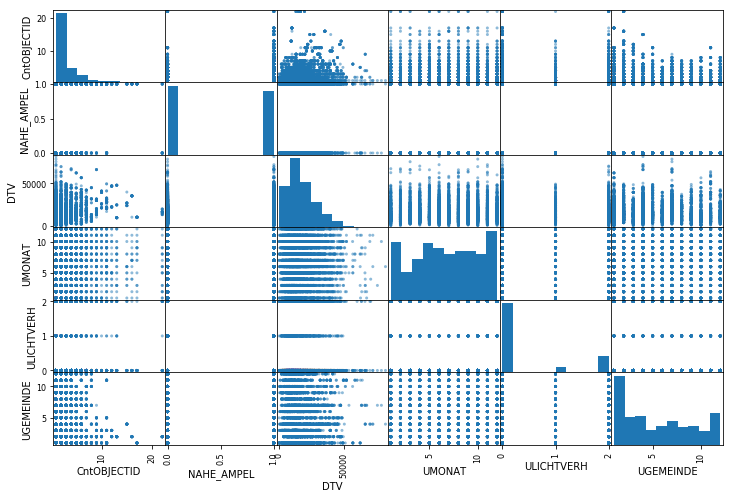

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["CntOBJECTID", "NAHE_AMPEL", "DTV","UMONAT","ULICHTVERH","UGEMEINDE"]
scatter_matrix(affected_crash_data[attributes], figsize=(12,8))

In [20]:
# Macht es eventuell Sinn Orte an denen es nur einen Unfall gab rauszuwerfen
cnt_crtl['CntOBJECTID'].value_counts()

1     681
2     280
3     136
4      83
5      56
6      37
7      20
8       9
9       8
11      4
10      4
13      2
12      2
17      1
16      1
15      1
Name: CntOBJECTID, dtype: int64

In [21]:
cnt_cwtl['CntOBJECTID'].value_counts()

1     1817
2      337
3       88
4       47
5       24
6       14
11       2
7        2
9        1
14       1
8        1
Name: CntOBJECTID, dtype: int64

In [22]:
#Einbeziehung weiterer Parameter
#Verkehrsmenge auf Straßenabschnitten <br/>
#Verkehrsmenge auf Straßenabschnitten ggf. Kategorisierung in hohes Verehrsaufkommen, mittleres, niedriges  <br/>
#Vergleich von Bezirken Anzahl Ampeln je durchschnittliche Verkehrsmenge <br/>
#Tempolimits einbringen <br/>

In [28]:
import matplotlib.pyplot as plt
plt.scatter(x=affected_crash_data["DTV"], y=affected_crash_data["CntOBJECTID"], c=affected_crash_data["NAHE_AMPEL"], alpha=0.1,cmap=plt.get_cmap("jet"))
plt.legend()

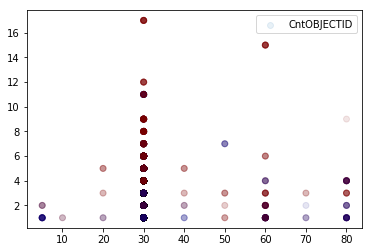

In [29]:
plt.scatter(x=affected_crash_data["WERT_VES"], y=affected_crash_data["CntOBJECTID"], c=affected_crash_data["NAHE_AMPEL"], alpha=0.1,cmap=plt.get_cmap("jet"))
plt.legend()


In [30]:
affected_crash_data_reduced = affected_crash_data[affected_crash_data['CntOBJECTID'] >= 2]
affected_crash_data_reduced['OBJECTID'].shape

(3700,)

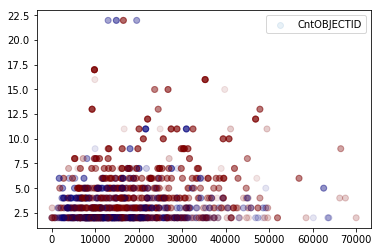

In [63]:
plt.scatter(x=affected_crash_data_reduced["DTV"], y=affected_crash_data_reduced["CntOBJECTID"], c=affected_crash_data_reduced["NAHE_AMPEL"], alpha=0.1,cmap=plt.get_cmap("jet"))
plt.legend()

In [20]:
affected_crash_data["DTV"].describe()

count     5362.000000
mean     17699.612272
std      11301.854668
min          0.000000
25%       9360.000000
50%      15300.000000
75%      24007.500000
max      82082.000000
Name: DTV, dtype: float64

In [24]:
affected_crash_data['DTV_GROUP'] = np.where(affected_crash_data['DTV'] < 9360, 1, np.where(affected_crash_data['DTV'] < 15300, 2, np.where(affected_crash_data['DTV'] < 24007, 3, np.where(affected_crash_data['DTV'] < 82082, 4, 5))))

In [26]:
affected_crash_data['DTV_GROUP'].value_counts()

3    1344
2    1341
4    1340
1    1336
5     802
Name: DTV_GROUP, dtype: int64

In [28]:
affected_crash_data.to_file("../01_Source/frage1_tableau.geojson")